In [1]:
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_community.vectorstores import Chroma

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import umap
from typing import Optional
import tiktoken
from sklearn.mixture import GaussianMixture
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
import os
embedding_model = GoogleGenerativeAIEmbeddings(
            model = "models/text-embedding-004",
            google_api_key = os.getenv("GEMINI_API_KEY")
        )

In [3]:
loader = DirectoryLoader(
    "./knowledge_base",
    glob = "**/*.txt",
    loader_cls= TextLoader
)
documents = loader.load()

# Split the documents

In [4]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1024,
    chunk_overlap = 128,
    length_function = len,
)

docs = text_splitter.split_documents(documents)
texts = [doc.page_content for doc in docs]

In [5]:
import tiktoken

def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [6]:
counts = [num_tokens_from_string(t) for t in texts]

<function matplotlib.pyplot.show(close=None, block=None)>

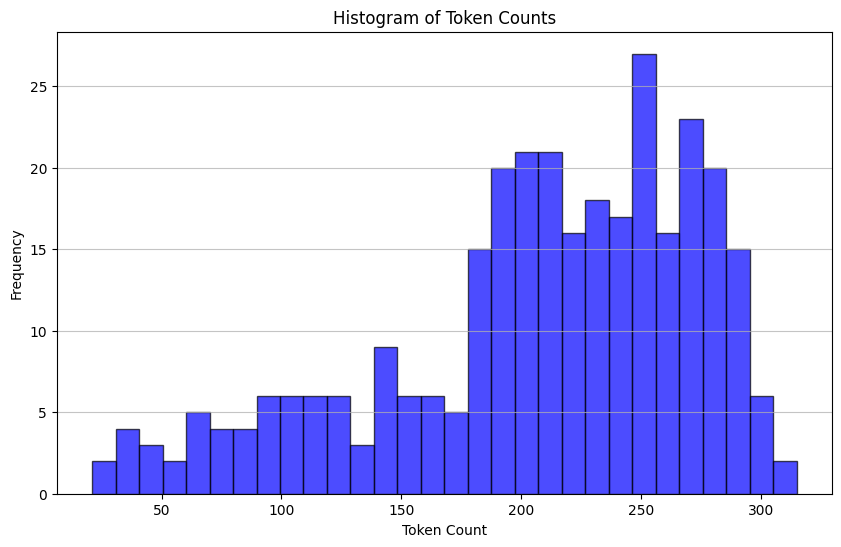

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show

In [8]:
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content))

Num tokens in all context: 65876


In [9]:

model  = ChatOpenAI(
    model_name = "mistralai/mistral-7b-instruct",
    openai_api_key = os.getenv("OPENROUTER_API_KEY"),
    openai_api_base = "https://openrouter.ai/api/v1",
    temperature = 0,
    streaming = True
)

In [10]:
global_embeddings = [embedding_model.embed_query(txt) for txt in texts]

In [11]:
global_embeddings[0]

[0.0064367325976490974,
 0.04934467375278473,
 -0.007498479913920164,
 -0.051208265125751495,
 -0.03564238175749779,
 0.05039072781801224,
 0.027276793494820595,
 0.015958860516548157,
 -0.012734904885292053,
 0.0398852564394474,
 -0.01429147832095623,
 0.0316716730594635,
 0.0618504174053669,
 0.06374575197696686,
 0.06477175652980804,
 -0.03619847446680069,
 0.041582077741622925,
 0.058848533779382706,
 -0.05944615975022316,
 -0.01720954291522503,
 0.029914529994130135,
 -0.036775462329387665,
 0.0852528065443039,
 -0.011203642003238201,
 0.06874126195907593,
 -0.006198902148753405,
 0.027762649580836296,
 -0.020105769857764244,
 0.027200818061828613,
 -0.008786340244114399,
 0.003489307826384902,
 -0.036899104714393616,
 0.0027028617914766073,
 -0.08851554244756699,
 0.03795503452420235,
 -0.04781822860240936,
 -0.04826978221535683,
 -0.04561843350529671,
 0.03883131965994835,
 -0.034847136586904526,
 -0.07073400914669037,
 -0.09735618531703949,
 -0.05556906759738922,
 0.00598627049

In [12]:
from umap.umap_ import UMAP

def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)
global_embeddings_reduced[0]


/home/olande/Langchain/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


array([-4.124199 ,  5.0602617], dtype=float32)

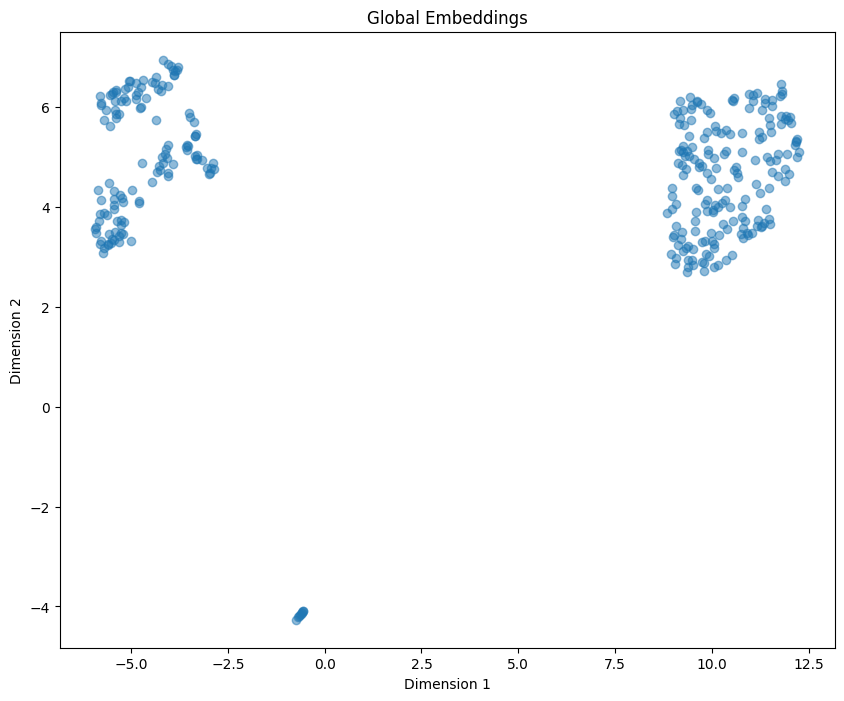

In [13]:
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [14]:
def get_optimal_clusters(embeddings: np.ndarray, max_clusters: int = 50, random_state: int = 1234):
    max_clusters = min(max_clusters, len(embeddings))
    bics = [GaussianMixture(n_components=n, random_state=random_state).fit(embeddings).bic(embeddings)
            for n in range(1, max_clusters)]
    return np.argmin(bics) + 1

def gmm_clustering(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state).fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

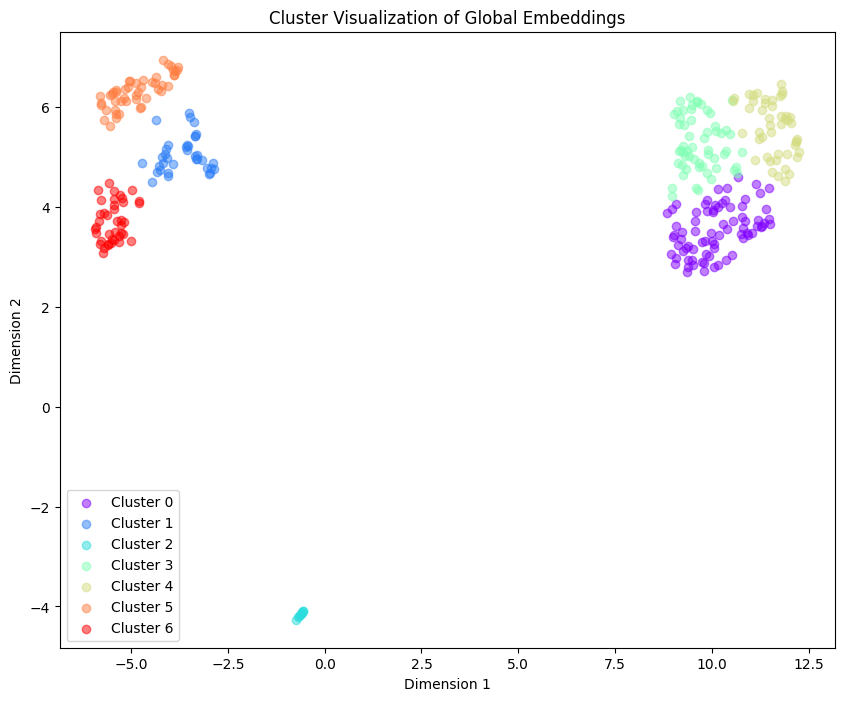

In [15]:
labels, _ = gmm_clustering(global_embeddings_reduced, threshold=0.5)

plot_labels = np.array([label[0] if len(label) > 0 else -1 for label in labels])
plt.figure(figsize=(10, 8))

unique_labels = np.unique(plot_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = plot_labels == label
    plt.scatter(global_embeddings_reduced[mask, 0], global_embeddings_reduced[mask, 1], color=color, label=f'Cluster {label}', alpha=0.5)

plt.title("Cluster Visualization of Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

In [16]:
import pandas as pd

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

df = pd.DataFrame({
    'Text': texts,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': simple_labels
})
print(df.head(3))

                                                Text               Embedding  \
0  ﻿﻿\nTHE DECLARATION OF INDEPENDENCE OF THE UNI...  [-4.124199, 5.0602617]   
1  We hold these truths to be self-evident, that ...   [-4.039026, 5.247968]   
2  the forms to which they are accustomed.  But w...   [-3.588536, 5.200343]   

   Cluster  
0        1  
1        1  
2        1  


In [17]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Text'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

In [18]:
clustered_texts = format_cluster_texts(df)
clustered_texts

{np.int64(1): '\ufeff\ufeff\nTHE DECLARATION OF INDEPENDENCE OF THE UNITED STATES OF AMERICA\n\n\nWhen in the Course of human events, it becomes necessary for\none people to dissolve the political bands which have connected\nthem with another, and to assume, among the Powers of the earth,\nthe separate and equal station to which the Laws of Nature and\nof Nature\'s God entitle them, a decent respect to the opinions\nof mankind requires that they should declare the causes which\nimpel them to the separation. --- We hold these truths to be self-evident, that all men are created equal,\nthat they are endowed by their Creator with certain unalienable Rights,\nthat among these are Life, Liberty, and the pursuit of Happiness.\nThat to secure these rights, Governments are instituted among Men,\nderiving their just powers from the consent of the governed,\nThat whenever any Form of Government becomes destructive of these ends,\nit is the Right of the People to alter or to abolish it, and to in

In [19]:
template = """You are an assistant to create a detailed summary of the text input prodived.
Text:
{text}
"""
prompt = ChatPromptTemplate.from_template(template)
chain = prompt | model | StrOutputParser()

In [20]:
summaries = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary

print(summaries)


{np.int64(1): " The Declaration of Independence of the United States of America was adopted by the Continental Congress on July 4, 1776. It is a historic document that outlines the colonists' grievances against the British government and justifies their decision to separate from Great Britain and establish a new nation.\n\nThe Declaration begins by stating that all men are created equal and have certain unalienable rights, including life, liberty, and the pursuit of happiness. It asserts that governments are instituted to secure these rights and that it is the right of the people to alter or abolish any government that becomes destructive of these ends.\n\nThe document then lists a series of grievances against the British government, including the refusal to pass laws, the quartering of troops among the colonists, the imposition of taxes without the consent of the colonists, and the abolition of their charters and laws. The colonists argue that these actions are a violation of their ri

In [21]:
embedded_summaries = [embedding_model.embed_query(summary) for summary in summaries.values()]

embedded_summaries_np = np.array(embedded_summaries)

labels, _ = gmm_clustering(embedded_summaries_np, threshold=0.5)

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

In [22]:
clustered_summaries = {}
for i, label in enumerate(simple_labels):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(list(summaries.values())[i])

In [23]:
print(clustered_summaries)

{np.int64(0): [" The Declaration of Independence of the United States of America was adopted by the Continental Congress on July 4, 1776. It is a historic document that outlines the colonists' grievances against the British government and justifies their decision to separate from Great Britain and establish a new nation.\n\nThe Declaration begins by stating that all men are created equal and have certain unalienable rights, including life, liberty, and the pursuit of happiness. It asserts that governments are instituted to secure these rights and that it is the right of the people to alter or abolish any government that becomes destructive of these ends.\n\nThe document then lists a series of grievances against the British government, including the refusal to pass laws, the quartering of troops among the colonists, the imposition of taxes without the consent of the colonists, and the abolition of their charters and laws. The colonists argue that these actions are a violation of their r

In [24]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

In [25]:
print(final_summaries)

{np.int64(0): " The Declaration of Independence was adopted by the Continental Congress on July 4, 1776, outlining the colonists' grievances against the British government and justifying their decision to separate and establish a new nation. It asserts that all men are created equal with unalienable rights to life, liberty, and the pursuit of happiness, and that governments are instituted to secure these rights. The document lists a series of grievances against the British government, including the imposition of taxes without consent, the quartering of troops, and the abolition of charters and laws. The Declaration concludes by declaring the thirteen colonies to be free and independent states, absolved from allegiance to the British Crown, and dissolving all political connection with Great Britain.\n\nThe United States Bill of Rights is a collection of the first ten amendments to the United States Constitution, passed by Congress on September 25, 1789, and ratified by three-fourths of 

In [26]:
texts_from_df = df['Text'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

In [27]:
# Now, use all_texts to build the vectorstore with Chroma
vectorstore = Chroma.from_texts(texts=combined_texts, embedding=embedding_model)

In [28]:
def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while final_number < max_threshold:
        retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})
        docs = retriever.get_relevant_documents(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 1
        else:
            break
    return final_number

final_number = adjust_final_number("Who is Chris Olande?", 10000, 4)

/tmp/ipykernel_2957/3311143107.py:5: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(string)


In [29]:
print(final_number)

52


In [30]:
retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})

In [31]:

template = """
Answer the question based only on the following context:
{context}

Answer the following question:
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [32]:
# Question
rag_chain.invoke("What grievances were made against the King?")

' The grievances made against the King in the Declaration of Independence include:\n\n1. He has refused his Assent to Laws, the most wholesome and necessary for the public good.\n2. He has forbidden his Governors to pass Laws of immediate and pressing importance, unless suspended in their operation till his Assent should be obtained; and when so suspended, he has utterly neglected to attend to them.\n3. He has refused to pass other Laws for the accommodation of large districts of people, unless those people would relinquish the right of Representation in the Legislature, a right inestimable to them and formidable to tyrants only.\n4. He has called together legislative bodies at places unusual, uncomfortable, and distant from the depository of their Public Records, for the sole purpose of fatiguing them into compliance with his measures.\n5. He has dissolved Representative Houses repeatedly, for opposing with manly firmness his invasions on the rights of the people.\n6. He has endeavore

In [ ]:
# Question
rag_chain.invoke("Who is chris olande?")